In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def calculate_atr_adjusted_upper_shadow(df, rsi_window=14, atr_window=14):
    """
    波动率调整的上影线因子
    金融学原理：
    1. 用ATR标准化消除市场波动影响
    2. 结合VIX原理，高波动市场中的上影线更具信息量
    3. 引入taker_buy_ratio捕捉机构资金流向
    """
    # 计算ATR
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=atr_window)
    
    # 计算RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # 计算机构买入比率
    df['taker_buy_ratio'] = df['taker_buy_volume'] / df['volume']
    
    # 核心因子计算
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = (df['high'] - max_open_close) / df['atr']  # ATR标准化
    
    # 增强信号：超买区且机构卖出
    enhanced_signal = np.where(
        (df['rsi'] > 70) & (df['taker_buy_ratio'] < 0.5),
        upper_shadow * 1.8,
        upper_shadow
    )
    
    # 尾部处理：设置最小波动阈值
    return np.where(df['atr'] < 0.001 * df['close'], np.nan, enhanced_signal)

# 因子测试

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_atr_adjusted_upper_shadow,
    factor_name='calculate_atr_adjusted_upper_shadow'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006581
   Rank_IC (Spearman): 0.000490
📊 信息比率:
   IR: -0.427647
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 129608
   因子列: calculate_atr_adjusted_upper_shadow
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


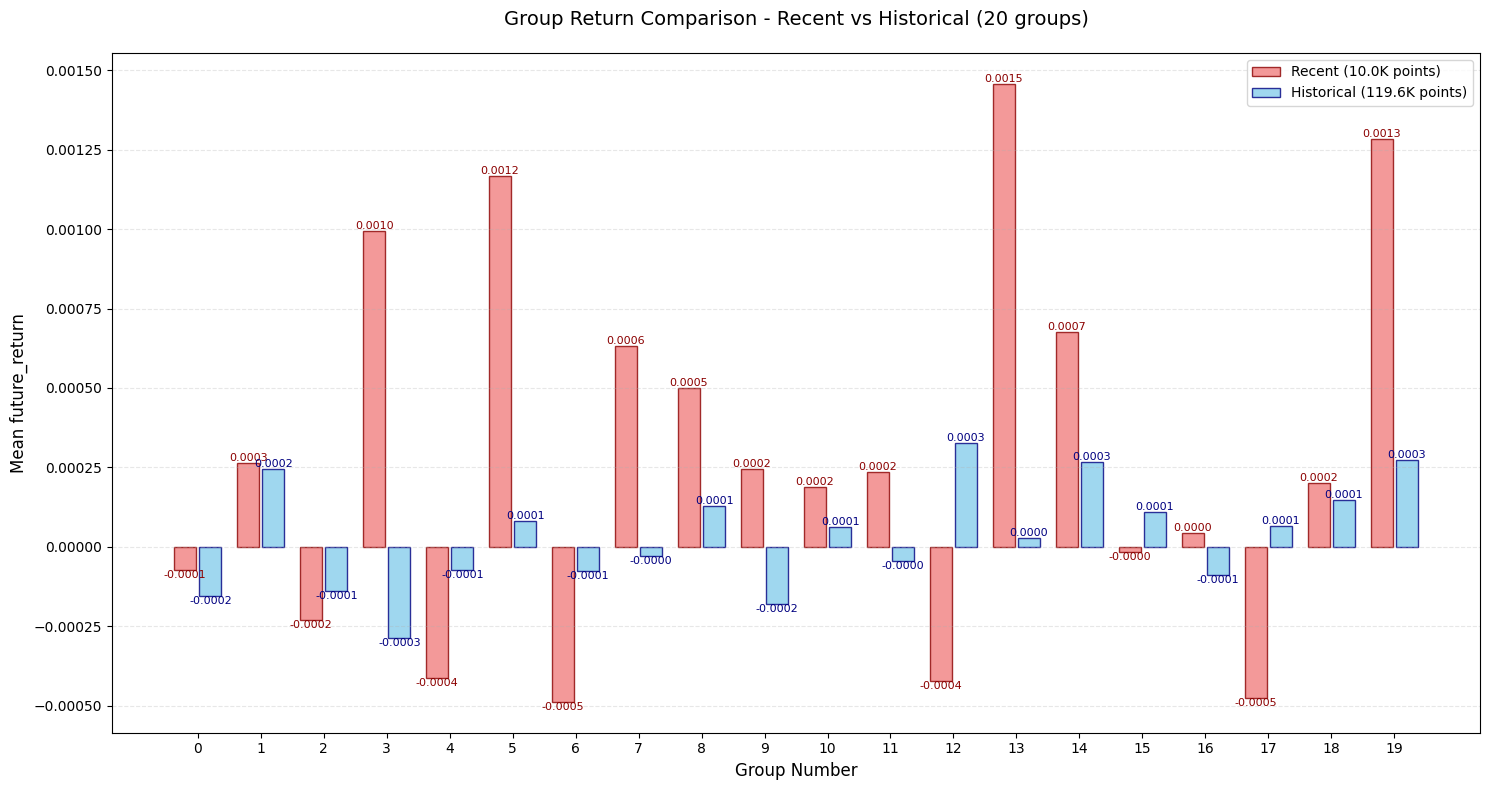

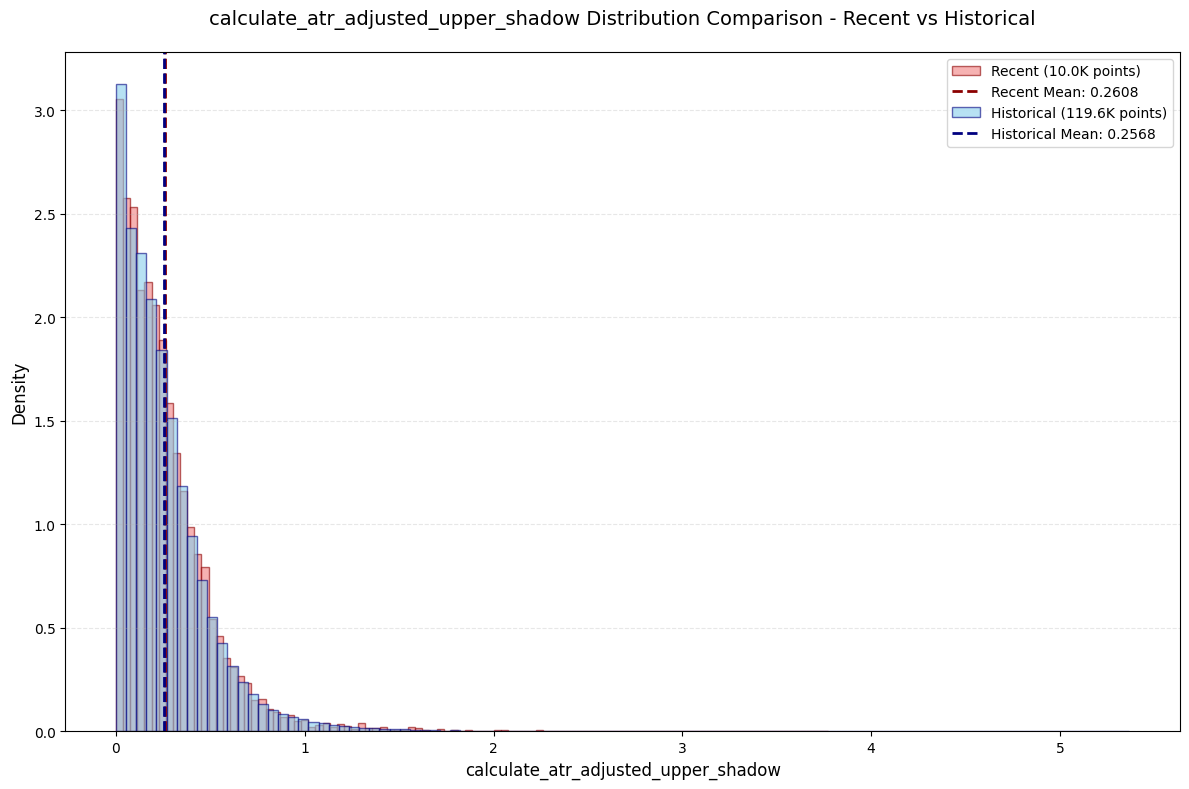

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)